## Loading

In [1]:
%load_ext autoreload
%autoreload 2

import model as m
import data_processing as dp
import feature_engineering as fe
import make_plots as mp
import parameters as p
import evaluation as e

import pandas as pd
import numpy as np

import os


default_max_rows = pd.get_option('display.max_rows')

In [4]:
# assert len(p.missing_files) == 0
# merged_data_daily, merged_data_monthly = dp.data_loading(p.daily_files, p.monthly_files)
# merged_data_daily = dp.get_market_data(merged_data_daily)
# merged_data_daily = fe.calculate_stock_level_alpha_and_beta(merged_data_daily)
# merged_data_monthly = dp.merge_economic_data(merged_data_monthly)
# dp.save_preprocessed_data(merged_data_monthly, "merged_data_monthly"); dp.save_preprocessed_data(merged_data_daily, "merged_data_daily", index=False)
merged_data_daily, merged_data_monthly = dp.data_loading(p.daily_files, p.monthly_files)

Loading daily data from existing file.
Loading monthly data from existing file.


In [72]:
data_daily, data_monthly = fe.feature_construction(merged_data_daily.copy(), merged_data_monthly.copy())
data_monthly_merged = dp.merge_daily_and_monthly_data(data_daily, data_monthly)

# dp.save_preprocessed_data(data_monthly_merged, "data_monthly_merged")
# data_monthly_merged = pd.read_csv(os.path.join(p.cleanedDataPath, "data_monthly_merged.csv"), index_col='date', dtype={p.stockID: str}, parse_dates=True)

Calculating Daily Features
Calculating Technical Indicators
Calculating Monthly Features


In [88]:
data_monthly_merged['zero_trade_days'].groupby('date').apply(lambda x: x.isna().mean())

date
2012-01-31    1.000000
2012-02-29    0.019405
2012-03-31    0.031104
2012-04-30    0.036441
2012-05-31    0.013025
                ...   
2023-11-30    0.001717
2023-12-31    0.004377
2024-01-31    0.001899
2024-02-29    0.000949
2024-03-31    0.001138
Name: zero_trade_days, Length: 147, dtype: float64

In [77]:
cols_to_drop = ["close", "beta_000905", "return_daily", "000905_return_daily"]
data_monthly_imputed = dp.handle_crosssectional_na(data_monthly_merged.drop(cols_to_drop, axis=1))
data_monthly_transformed = fe.transform_features(data_monthly_imputed)

Dropped 4308 rows with more than 57.127356200402744% missing values.


Increase in missing statistics for each column:
daily_ret_vol_roll_126: 0.47%
total_market_value: 5.53%
turnover_daily: 5.53%
000905_close: 0.00%
000905_return_monthly: 0.44%
alpha: 6.99%
beta: 6.99%
betasq: 6.99%
maxret: 0.00%
MACD: 0.00%
MACD_Signal: 0.00%
SMA: 0.00%
Upper_Band: 0.03%
Lower_Band: 0.00%
RSI: 3.02%
ROC: 0.31%
volatility_252: 7.14%
volatility_120: 3.73%
volatility_60: 2.10%
SMA_5: 0.00%
SMA_10: 0.00%
SMA_20: 0.00%
SMA_50: 0.00%
SMA_100: 0.00%
SMA_200: 0.00%
illiquidity_monthly: 1.01%
mve_log: 6.66%
return_monthly: 0.98%
ret_vol_monthly: 0.98%
std_dolvol_monthly: 1.01%
std_turnover_monthly: 6.40%
zero_trade_days: 1.25%
CPI: 0.96%
CPI_pct_change: 0.96%
chmom: 10.99%
mom1m: 1.55%
mom12m: 7.37%
mom6m: 4.29%
mom24m: 12.95%
mom36m: 17.47%
excess_return: 0.98%
y: 0.97%


## Baseline Model

In [63]:
data_monthly_nona = data_monthly_imputed.dropna().copy()
removed_percentage = (1 - len(data_monthly_nona) / len(data_monthly_imputed)) * 100
print(f"Removed {len(data_monthly_nona)} rows, which is {removed_percentage:.2f}%.")

Removed 416682 rows, which is 19.30%.


In [15]:
price_return_related = ['close', 'close_adj', 'return_daily', '000905_close', 
                        '000905_return_daily', '000905_return_monthly', 'return_monthly',
                        'alpha', 'beta'
                        ]              

data_baseline = data_monthly_nona.drop(price_return_related,axis=1)

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = m.split_train_val_test(data_baseline.copy(), colsToDrop = ['excess_return'])
input_dim=X_train.shape[1]

print("Training set range:")
print(X_train.index.min(), "to", X_train.index.max())

print("Validation set range:")
print(X_val.index.min(), "to", X_val.index.max())

print("Testing set range:")
print(X_test.index.min(), "to", X_test.index.max())

Training set range:
2015-03-31 00:00:00 to 2021-05-31 00:00:00
Validation set range:
2021-05-31 00:00:00 to 2022-11-30 00:00:00
Testing set range:
2022-11-30 00:00:00 to 2024-03-31 00:00:00


### Hyperparameter tuning

In [6]:
# models_to_tune = [
#     m.OLSModel,
#     m.OLS3Model,
#     m.PLSModel,
#     m.LASSOModel,
#     m.ElasticNetModel,
#     m.GBRTModel,
#     m.RFModel,
#     m.XGBoostModel
# ]
# models_to_tune = [
#     m.XGBoostModel
# ]
# best_trials = e.hyperparameter_tuning(X_train, y_train, X_val, y_val, models_to_tune, n_trials=100)

In [7]:
# e.nn_tunning(range(1, 5+1), X_train, y_train, X_val, y_val)

### Testing

In [8]:
model_classes = [
    m.OLSModel(),
    m.OLS3Model(),
    m.PLSModel(),
    m.LASSOModel(),
    m.ElasticNetModel(),
    m.GBRTModel(), #extremely slow 
    m.RFModel(), 
    m.XGBoostModel()
]
num_layers_range = range(1, 5+1)
for num_layers in num_layers_range:
    model_classes.append(m.NNModel(input_dim=input_dim, num_layers=num_layers))
models_fitted, model_res, model_r_2 = m.fit_model(X_train, X_test,  X_val, y_val, y_train, y_test, model_classes)

OLSModel
OLS3Model
PLSModel
LASSOModel
ElasticNetModel
GBRTModel
RFModel
XGBoostModel
NNModel_nn1


Training:  10%|█         | 10/100 [01:23<12:28,  8.32s/it, Training loss=0.0218, Validation loss=0.02] 


Early stopping triggered at epoch 11
NNModel_nn2


Training:   7%|▋         | 7/100 [01:05<14:24,  9.29s/it, Training loss=0.0218, Validation loss=0.0203]


Early stopping triggered at epoch 8
NNModel_nn3


Training:   8%|▊         | 8/100 [01:21<15:32, 10.14s/it, Training loss=0.0218, Validation loss=0.0201]


Early stopping triggered at epoch 9
NNModel_nn4


Training:  10%|█         | 10/100 [01:58<17:45, 11.84s/it, Training loss=0.0218, Validation loss=0.02] 


Early stopping triggered at epoch 11
NNModel_nn5


Training:   5%|▌         | 5/100 [01:06<20:56, 13.23s/it, Training loss=0.0218, Validation loss=0.0201]

Early stopping triggered at epoch 6
OLSModel: -3.952722727443433
OLS3Model: -3.944255798884204
PLSModel: -3.9588289846051
LASSOModel: -3.957814939871847
ElasticNetModel: -3.957851629009099
GBRTModel: -3.978476442409592
RFModel: -4.262471221044477
XGBoostModel: -3.963006762336992
NNModel_nn1: -4.020113327689079
NNModel_nn2: -3.946702108982601
NNModel_nn3: -3.9590972154298
NNModel_nn4: -3.9614414022136
NNModel_nn5: -3.9706976659848072


### Feature Importance

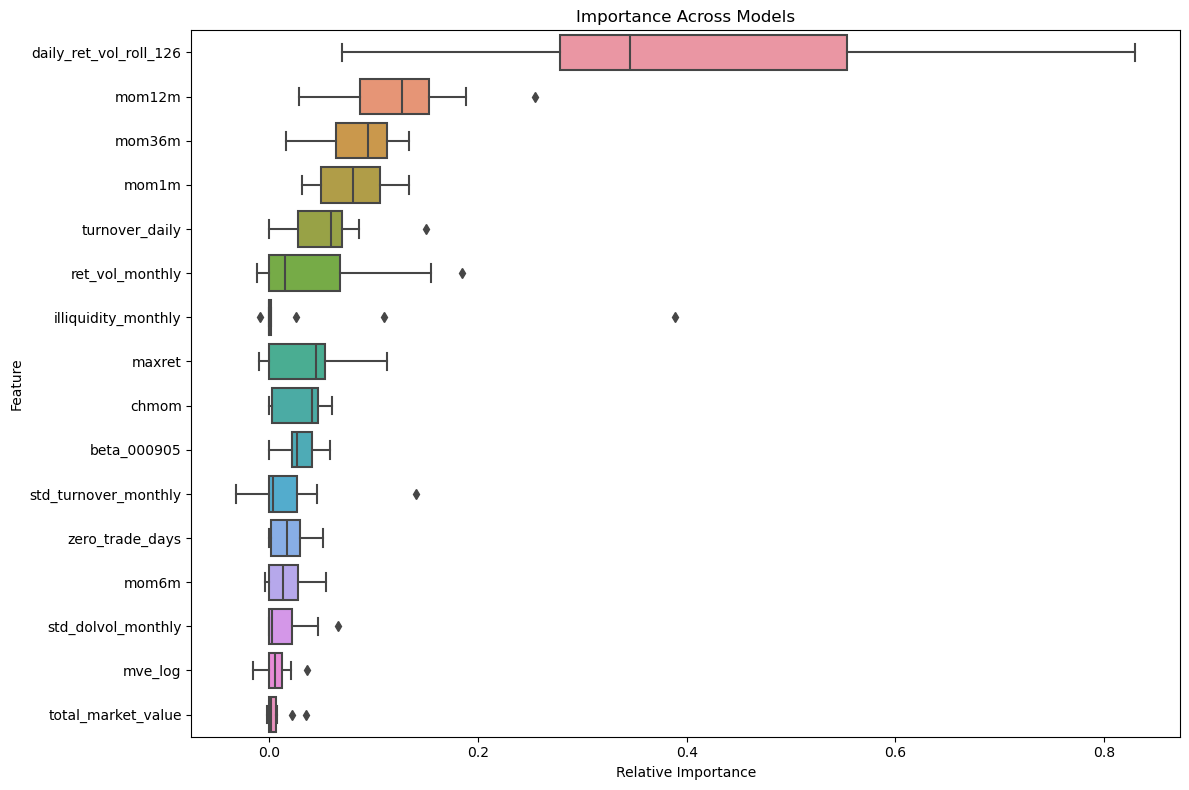

In [37]:
X_train, y_train, X_val, y_val, X_test, y_test = m.split_train_val_test(data_baseline.copy(), colsToDrop = ['excess_return'])
importance_df_baseline = e.feature_importance(model_classes, X_train, y_train, X_val, y_val, features=X_train.columns, permutation_importance=True)
mp.feature_importance_boxplot(importance_df_baseline)
# sorted_df = mp.characteristic_feature_importance(importance_df_baseline)

## Current Model

In [64]:
data_monthly_nona = data_monthly_imputed.dropna().copy()
removed_percentage = (1 - len(data_monthly_nona) / len(data_monthly_imputed)) * 100
print(f"Removed {len(data_monthly_nona)} rows, which is {removed_percentage:.2f}%.")

Removed 416682 rows, which is 19.30%.


In [67]:
price_return_related = ['return_daily', 
                        '000905_return_daily', 'beta_000905'
                        ]              

data_crruent = data_monthly_nona.drop(price_return_related,axis=1)

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = m.split_train_val_test(data_crruent.copy(), colsToDrop = ['excess_return'])
input_dim=X_train.shape[1]

print("Training set range:")
print(X_train.index.min(), "to", X_train.index.max())

print("Validation set range:")
print(X_val.index.min(), "to", X_val.index.max())

print("Testing set range:")
print(X_test.index.min(), "to", X_test.index.max())

Training set range:
2015-03-31 00:00:00 to 2021-05-31 00:00:00
Validation set range:
2021-05-31 00:00:00 to 2022-11-30 00:00:00
Testing set range:
2022-11-30 00:00:00 to 2024-03-31 00:00:00


### Hyperparameter tuning

In [8]:
models_to_tune = [
    # m.OLSModel,
    # m.OLS3Model,
    # m.PLSModel,
    # m.LASSOModel,
    # m.ElasticNetModel,
    # m.GBRTModel,
    # m.RFModel,
    # m.XGBoostModel
]
best_trials = e.hyperparameter_tuning(X_train, y_train, X_val, y_val, models_to_tune, n_trials=100)

Tuning Models:   0%|          | 0/5 [00:00<?, ?it/s]


TypeError: 'NNModel' object is not callable

### Testing

In [11]:
model_classes = [
    m.OLSModel(),
    m.OLS3Model(),
    # m.PLSModel(),
    m.LASSOModel(),
    m.ElasticNetModel(),
    # m.GBRTModel(), #extremely slow 
    # m.RFModel(), 
    m.XGBoostModel()
]
num_layers_range = range(1, 5+1)
for num_layers in num_layers_range:
    model_classes.append(m.NNModel(input_dim=input_dim, num_layers=num_layers))
models_fitted, model_res, model_r_2 = m.fit_model(X_train, X_test,  X_val, y_val, y_train, y_test, model_classes)

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

OLSModel


Testing:  10%|█         | 1/10 [00:01<00:07,  1.23it/s, Model Name=OLS3Model, R_2=-3.94]

OLS3Model


Testing:  30%|███       | 3/10 [00:01<00:02,  3.26it/s, Model Name=LASSOModel, R_2=-3.96]

LASSOModel
ElasticNetModel


Testing:  40%|████      | 4/10 [00:01<00:01,  4.25it/s, Model Name=ElasticNetModel, R_2=-3.96]

XGBoostModel


Testing:  50%|█████     | 5/10 [00:17<00:29,  5.93s/it, Model Name=XGBoostModel, R_2=-4.1]    

NNModel_nn1


Testing:  60%|██████    | 6/10 [02:03<02:39, 39.89s/it, Model Name=NNModel_nn1, R_2=-4.02]

Early stopping triggered at epoch 18
NNModel_nn2


Testing:  60%|██████    | 6/10 [03:45<02:30, 37.65s/it, Model Name=NNModel_nn1, R_2=-4.02]


KeyboardInterrupt: 

### Feature Importance

Training:  11%|█         | 11/100 [01:34<12:45,  8.60s/it, Training loss=0.0217, Validation loss=0.0202]  

Early stopping triggered at epoch 12



Training:   7%|▋         | 7/100 [01:06<14:49,  9.56s/it, Training loss=0.0217, Validation loss=0.0201]

Early stopping triggered at epoch 8



Training:  13%|█▎        | 13/100 [02:13<14:54, 10.29s/it, Training loss=0.0217, Validation loss=0.0201]

Early stopping triggered at epoch 14



Training:   6%|▌         | 6/100 [01:16<19:59, 12.76s/it, Training loss=0.0219, Validation loss=0.0201]

Early stopping triggered at epoch 7



Training:   5%|▌         | 5/100 [01:07<21:24, 13.52s/it, Training loss=0.0219, Validation loss=0.02]5]

Early stopping triggered at epoch 6



Calculating Feature Importance: 100%|██████████| 13/13 [13:02<00:00, 60.20s/it, Model Name=NNModel_nn5]


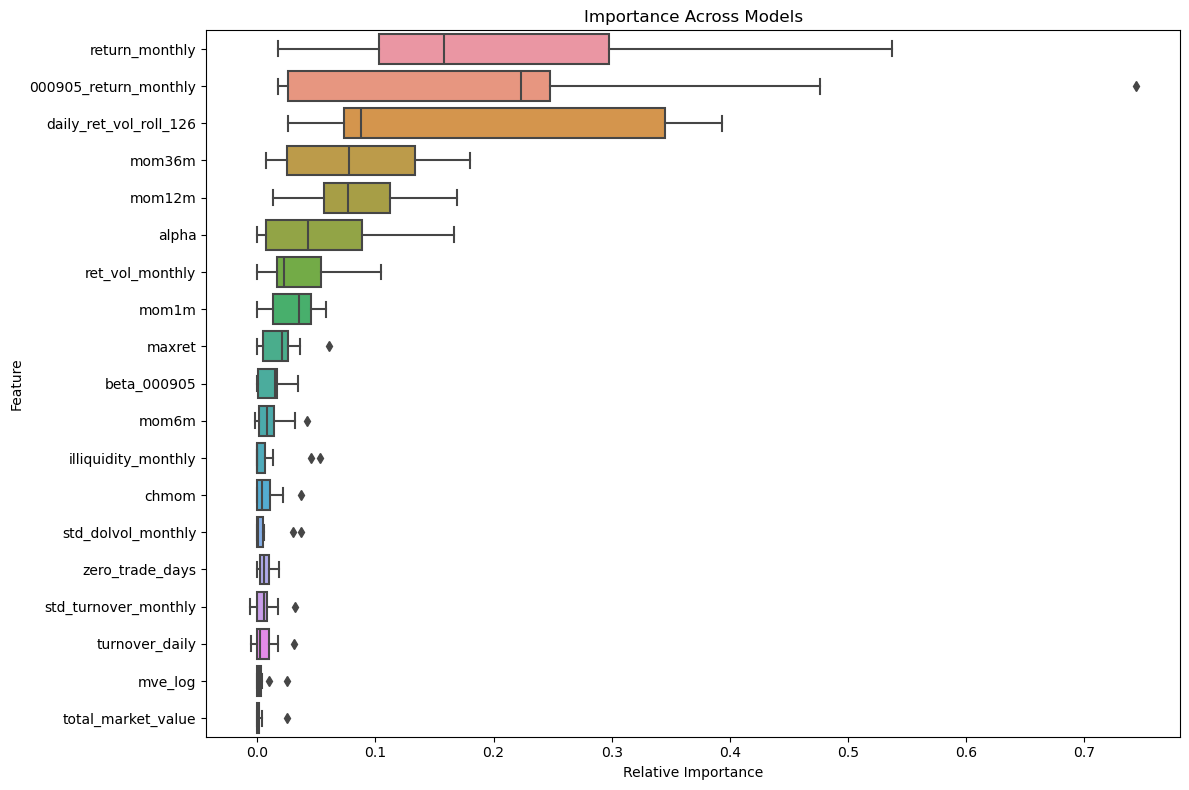

In [62]:
X_train, y_train, X_val, y_val, X_test, y_test = m.split_train_val_test(data_crruent.copy(), colsToDrop = ['excess_return'])
importance_df_current = e.feature_importance(model_classes, X_train, y_train, X_val, y_val, features=X_train.columns, permutation_importance=True)
mp.feature_importance_boxplot(importance_df_current)
# sorted_df = mp.characteristic_feature_importance(importance_df_current)

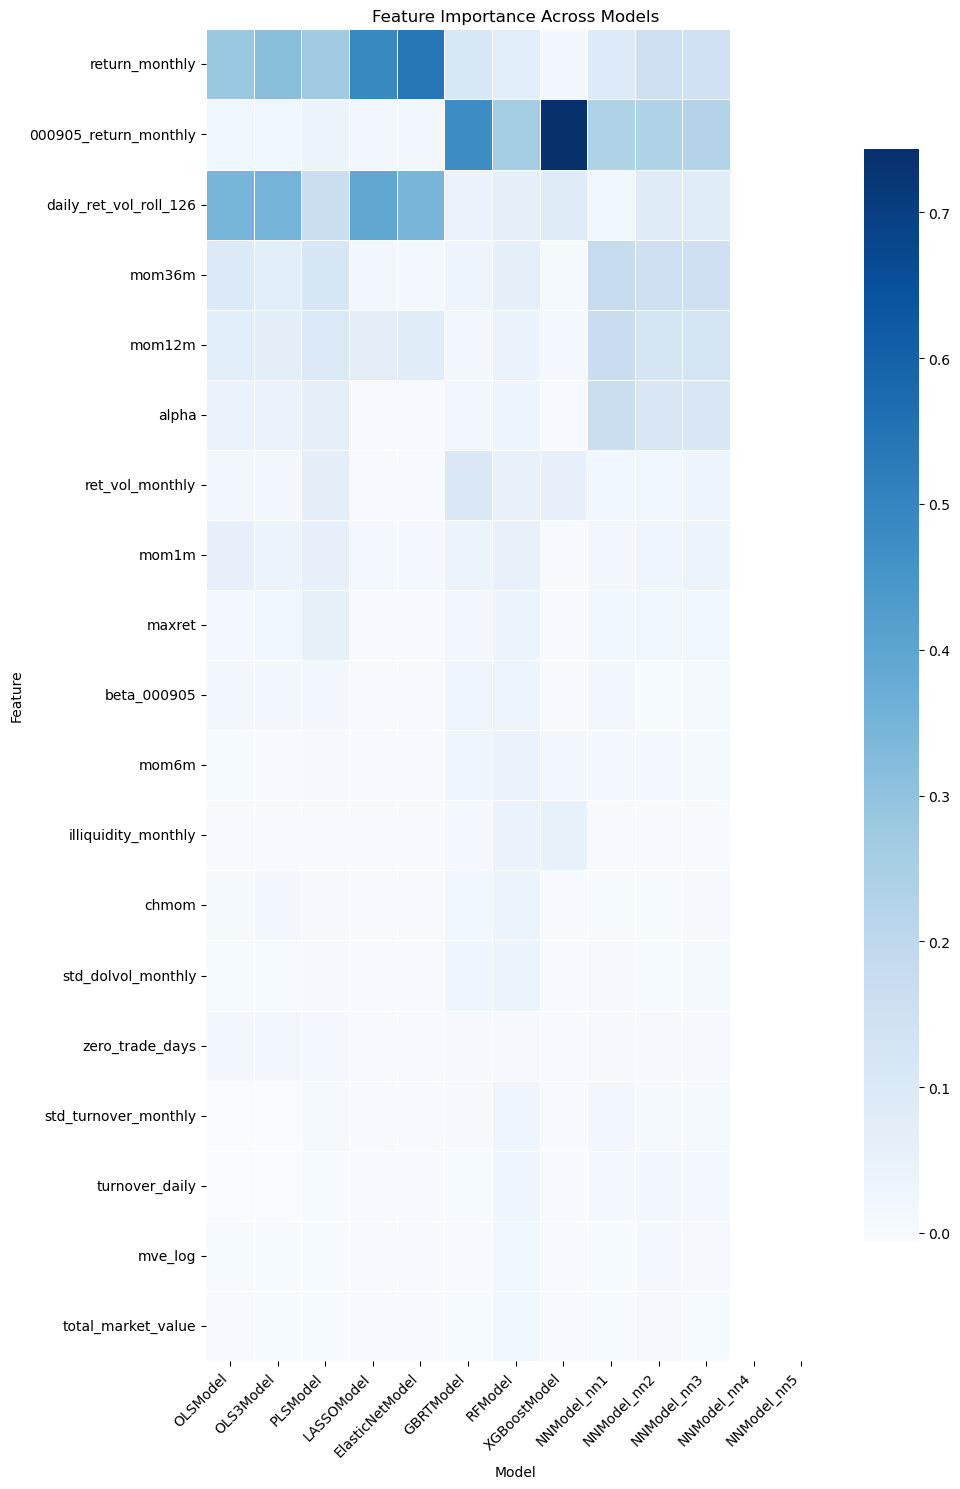

In [63]:
sorted_df = mp.characteristic_feature_importance(importance_df_current)

## Portfolio analysis